<a href="https://colab.research.google.com/github/Pantopelagienne/TP_Note_XAI/blob/main/TP_XAI_corrig%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  🧠 Comprendre son modèle de Machine Learning grâce à l'Explicabilité 🤖

[Google Form](https://docs.google.com/forms/d/e/1FAIpQLSeE30hbSmbQO8vjiT6UJdk9hAR6xOTpDks71E6BBre1dea0AA/viewform?usp=sf_link)

# 📥 Imports

In [4]:
# Installer les packages requis
!pip install pycaret explainerdashboard pycaret[analysis] --upgrade jupyter-dash shap lime tensorflow

  Using cached shap-0.45.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (540 kB)


In [32]:
# Importer les librairies nécessaires
import pandas as pd
from pycaret.classification import *
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
import shap
import lime.lime_tabular
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.cluster import KMeans

# 1- Utilisation d'un Explainer Dashboard 📊

**Objectif** : Dans cette première partie, vous apprendrez à créer  et analyser un tableau de bord interactif avec la librairie ExplainerDashboard qui vous aidera à visualiser et comprendre les performances et les prédictions du modèle.

Google Form : Page 2 Partie SHAP, Page 2 Partie Contrefactuelles

## Chargement des données

Caractéristiques du dataset :

*   Age
*   Sexe
* Job : Niveau de compétence et type de résidence (0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing : Type de logement (own, rent, or free)
* Saving accounts : Niveau des comptes d'épargne (little, moderate, quite rich, rich)
* Checking account : Montant des comptes courant
* Credit amount : Montant du crédit
* Duration : Durée du crédit en mois
* Purpose : Objet du crédit (car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [6]:
# Charger le dataset
dataset = pd.read_csv("/content/german_credit_data.csv", sep=",")
dataset.drop(columns=dataset.columns[0], axis=1, inplace=True)

In [7]:
# Définir la variable cible
target = "Risk"

## Entraînement du modèle

In [8]:
# Setup l'environnement PyCaret
exp1 = setup(dataset, target=target, session_id=123)

,Description,Value
0,Session id,123
1,Target,Risk
2,Target type,Binary
3,Target mapping,"bad: 0, good: 1"
4,Original data shape,"(1000, 10)"
5,Transformed data shape,"(1000, 24)"
6,Transformed train set shape,"(700, 24)"
7,Transformed test set shape,"(300, 24)"
8,Numeric features,4
9,Categorical features,5


In [9]:
# Comparer les modèles
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7114,0.6568,0.7114,0.6761,0.6627,0.1641,0.1935,1.8910
ridge,Ridge Classifier,0.7071,0.6562,0.7071,0.6653,0.6544,0.1442,0.1710,0.4890
lda,Linear Discriminant Analysis,0.7071,0.6560,0.7071,0.6698,0.6594,0.1559,0.1823,0.1430
dummy,Dummy Classifier,0.7000,0.5000,0.7000,0.4900,0.5765,0.0000,0.0000,0.2740
ada,Ada Boost Classifier,0.6957,0.6447,0.6957,0.6664,0.6660,0.1728,0.1886,0.4200
gbc,Gradient Boosting Classifier,0.6957,0.6579,0.6957,0.6617,0.6594,0.1579,0.1745,0.2900
rf,Random Forest Classifier,0.6871,0.6249,0.6871,0.6422,0.6469,0.1254,0.1360,0.7260
et,Extra Trees Classifier,0.6714,0.6112,0.6714,0.6392,0.6484,0.1355,0.1382,0.6030
lightgbm,Light Gradient Boosting Machine,0.6714,0.6433,0.6714,0.6551,0.6536,0.1578,0.1677,0.9140
xgboost,Extreme Gradient Boosting,0.6686,0.6361,0.6686,0.6521,0.6515,0.1588,0.1649,0.2070


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [10]:
# Entraîner le meilleur modèle
model = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6857,0.6569,0.6857,0.6383,0.6400,0.1057,0.1211
1,0.6714,0.5403,0.6714,0.5922,0.6020,0.0171,0.0223
2,0.7429,0.7755,0.7429,0.7248,0.7146,0.2913,0.3169
3,0.7000,0.7055,0.7000,0.6581,0.6503,0.1322,0.1568
4,0.6714,0.5899,0.6714,0.6217,0.6297,0.0800,0.0891
5,0.7429,0.7162,0.7429,0.7279,0.7055,0.2683,0.3073
6,0.6714,0.4684,0.6714,0.5922,0.6020,0.0171,0.0223
7,0.7571,0.7901,0.7571,0.7556,0.7169,0.2975,0.3527
8,0.7429,0.6696,0.7429,0.7365,0.6946,0.2437,0.3013


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
# Finaliser le modèle
final_model = finalize_model(model)

## Création de l'Explainer dashboard

In [12]:
# Remplir les valeurs manquantes pour les variables catégorielles
categorical_columns = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]
dataset[categorical_columns] = dataset[categorical_columns].fillna("missing")

In [13]:
X = dataset.drop(columns=['Risk'])
y = get_config("y_transformed")

In [14]:
# Créer un explainer pour le modèle
explainer = ClassifierExplainer(final_model, X, y, labels=['bad','good'])

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')


In [15]:
# Créer le dashboard
dashboard = ExplainerDashboard(explainer,
  importances=True,
  model_summary=False,
  contributions=True,
  whatif=True,
  shap_dependence=False,
  shap_interaction=False,
  decision_trees=False,
  title="Credit Risk Model Explainer",
  description="This dashboard provides insights into the credit risk model using SHAP.")

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating prediction probabilities...
Calculating metrics...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [16]:
# Lancez le dashboard
dashboard.run(port=8050)

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2- Comparaison de SHAP et LIME ⚖️

**Objectif** : Cette partie vous permettra de comparer deux méthodes d'explicabilité, SHAP et LIME, en les appliquant à un dataset de classification bien connu, le dataset Iris.

Google Form : Page 3

In [17]:
from sklearn.datasets import load_iris

# Charger le dataset Iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

In [18]:
# Setup PyCaret environment

exp2 = setup(X, target=y, session_id=123,  fold=3)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(150, 5)"
4,Transformed data shape,"(150, 5)"
5,Transformed train set shape,"(105, 5)"
6,Transformed test set shape,"(45, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [19]:
#Train a random forest
model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9429,0.9951,0.9429,0.9429,0.9429,0.9142,0.9142
1,0.8857,0.9801,0.8857,0.8922,0.8849,0.8284,0.8325
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Mean,0.9429,0.9918,0.9429,0.9450,0.9426,0.9142,0.9156
Std,0.0467,0.0085,0.0467,0.0440,0.0470,0.0700,0.0684


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
X_train = get_config('X_train')
X_test = get_config('X_test')
y_test = get_config('y_test')

In [21]:
predictions_test = predict_model(model, data=X_test)

## Calculer les explications avec SHAP et LIME

In [22]:
explainer_shap = shap.TreeExplainer(model)

In [23]:
shap_values = explainer_shap.shap_values(X_test)

In [24]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_test),
    feature_names=X_test.columns,
    class_names=iris.target_names,
    mode='classification'
)

In [25]:
# Choisir une observation à expliquer
observation_index = 12
observation = X_test.iloc[observation_index]

In [26]:
# Créer un objet Explanation à partir des valeurs SHAP
shap_values_observation = shap.Explanation(
    values=shap_values[1][observation_index],
    base_values=explainer_shap.expected_value[1],
    data=observation,
    feature_names=X_test.columns
)

In [27]:
explanation = explainer_lime.explain_instance(
    data_row=observation,
    predict_fn=model.predict_proba,
    num_features=len(X_test.columns)
)

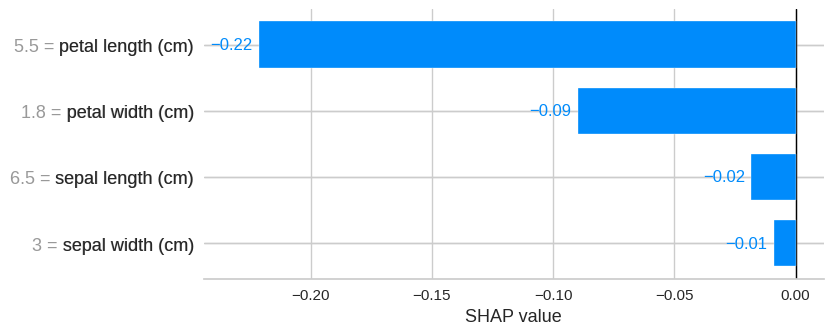

In [28]:
# Afficher le bar plot pour l'observation
shap.plots.bar(shap_values_observation)

In [29]:
explanation.show_in_notebook(show_table=True)

# 3- 🍋 Expliquer les prédictions d'un modèle avec LIME sur des images 🖼️

**Objectif** : Dans cette section, vous allez utiliser LIME pour expliquer les prédictions d'un modèle de classification d'images pré-entraîné, VGG16. Vous apprendrez à identifier et interpréter les régions de l'image qui influencent le plus les prédictions du modèle, vous permettant ainsi de mieux comprendre comment et pourquoi le modèle prend certaines décisions.

Google Form : Page 4

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02106030', 'collie', 0.3977407), ('n02106166', 'Border_collie', 0.13289562), ('n02110063', 'malamute', 0.078388944)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5

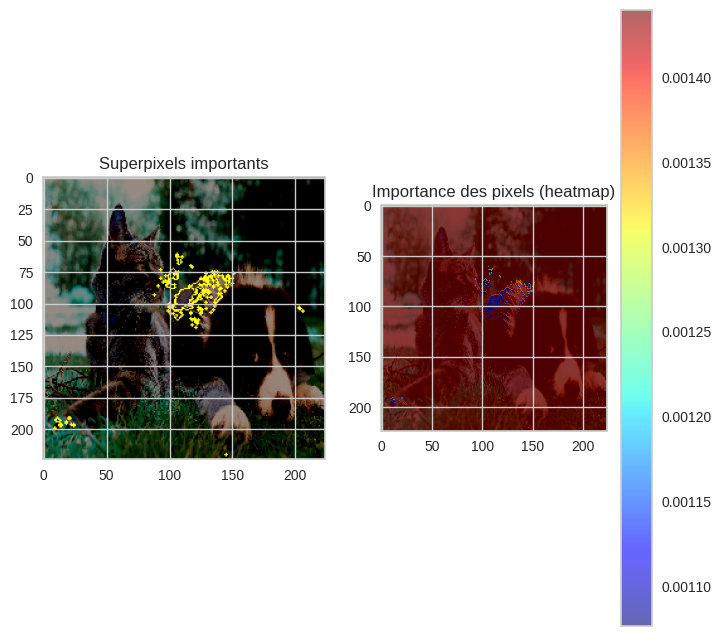

In [30]:
# Charger le modèle pré-entraîné VGG16
model = VGG16(weights='imagenet')

# Fonction pour charger et prétraiter l'image
def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Chemin de l'image à expliquer
img_path = "/content/intelligence-chiens-chats.jpeg"

# Charger et prétraiter l'image
img = load_image(img_path)

# Prédire l'étiquette de l'image
preds = model.predict(img)
print('Predicted:', decode_predictions(preds, top=3)[0])

# Fonction de prédiction pour LIME
def predict(images):
    images = preprocess_input(images)
    return model.predict(images)

# Initialiser l'explainer de LIME
explainer = lime_image.LimeImageExplainer()

# Expliquer la prédiction de l'image
explanation = explainer.explain_instance(img[0].astype('double'),
                                         predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

# Obtenir la superpixel et le masque pour l'explication
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5,
                                            hide_rest=False)

# Créer une heatmap en fonction des superpixels importants
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("Superpixels importants")

# Créer une heatmap des importances des superpixels
importance = explanation.local_exp[explanation.top_labels[0]]
heatmap = np.zeros(mask.shape)
for superpixel, weight in importance:
    heatmap[mask == superpixel] = weight

# Afficher l'image originale avec la heatmap
plt.subplot(1, 2, 2)
plt.imshow(temp / 255.0)
plt.imshow(heatmap, cmap='jet', alpha=0.6)  # Utiliser cmap pour le gradient de couleur
plt.title("Importance des pixels (heatmap)")
plt.colorbar()

plt.show()

# 4- Clusters d'explications 🗂️

**Objectif** : Dans cette section, vous allez explorer comment les valeurs SHAP peuvent être utilisées pour créer des clusters d'explications.

Références : [How to make the most of local explanations: effective
clustering based on influences](https://hal.science/hal-04189455/document)

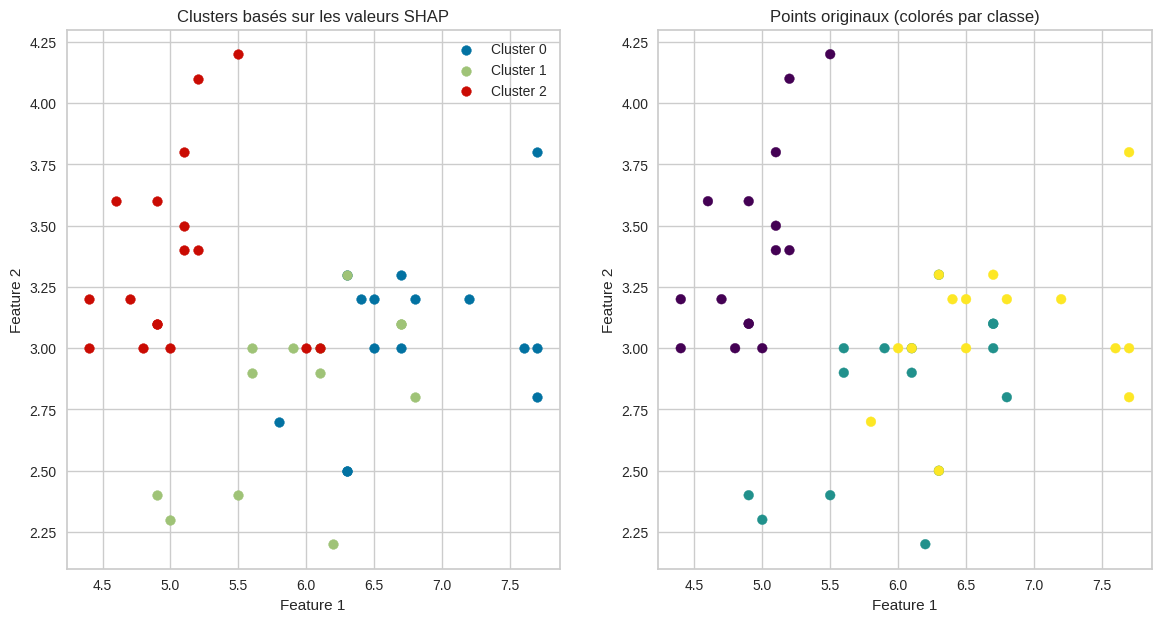

In [33]:
# Utiliser KMeans pour créer des clusters basés sur les valeurs SHAP
kmeans = KMeans(n_clusters=3, random_state=123)
shap_values_all = shap_values[1]  # Prendre les valeurs SHAP pour la classe d'intérêt
kmeans.fit(shap_values_all)
clusters = kmeans.predict(shap_values_all)

# Ajouter les clusters aux données
X_test_with_clusters = X_test.copy()
X_test_with_clusters['Cluster'] = clusters

# Visualiser les clusters
plt.figure(figsize=(14, 7))

# Graphique des clusters basés sur les valeurs SHAP
plt.subplot(1, 2, 1)
for cluster in range(3):
    cluster_data = X_test_with_clusters[X_test_with_clusters['Cluster'] == cluster]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster}', cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters basés sur les valeurs SHAP')
plt.legend()

# Graphique des points originaux pour comparaison
plt.subplot(1, 2, 2)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Points originaux (colorés par classe)')

plt.show()

# 🦆